In [1]:
import random
%load_ext autoreload
%autoreload 2

import json
import networkx as nx
from copy import deepcopy

import matplotlib.pyplot as plt
import numpy as np
import causalicp as icp
r = np.random  # Random generator
r.seed(1)
from pm4py.algo.discovery.dcr_discover import algorithm as dcr_alg
from pm4py.util.external_functions import *
from data_aware_helper import *

In [2]:
road_traffic = pm4py.read_xes('/home/vco/Datasets/Road_Traffic_Fine_Management_Process.xes.gz')

parsing log, completed traces ::   0%|          | 0/150370 [00:00<?, ?it/s]

In [3]:
road_traffic_train = road_traffic
# road_traffic_train, road_traffic_test = temporal_split(road_traffic,.3)
events = set(road_traffic_train['concept:name'].unique())
data_attributes = set(road_traffic_train.columns).difference({'org:resource','lifecycle:transition','concept:name','time:timestamp','case:concept:name'})
event_data_attributes = {}
for event in events:
    event_data_attributes[event] = extract_event_data_attributes(road_traffic_train,event,data_attributes)
domain_knowledge = {
    'Insert Fine Notification': {'lastSent':'categorical','notificationType':'categorical'},
    'Payment': {'paymentAmount':'numerical','totalPaymentAmount':'numerical'},
    'Appeal to Judge':{'dismissal':'categorical','matricola':'ignore'},
    'Add penalty': {'amount':'numerical'},
    'Send Appeal to Prefecture': {'dismissal': 'categorical'},
    'Send Fine': {'expense':'numerical'},
    'Create Fine': {'vehicleClass':'categorical','dismissal':'categorical','amount':'numerical','points':'numerical','article':'numerical','totalPaymentAmount':'numerical'}
}
events_no_data = set(road_traffic_train['concept:name'].unique()).difference(domain_knowledge.keys())
traffic_train_model, log_abs = dcr_alg.apply(road_traffic_train)
events_and_data = set(road_traffic_train['concept:name'].unique())

[i] Mining with basic DisCoveR
[i] Converting to old event log!


/home/vco/Projects/pm4py-dcr/pm4py/utils.py:494: UserWarning: the EventLog class has been deprecated and will be removed in a future release.
  warnings.warn("the EventLog class has been deprecated and will be removed in a future release.")


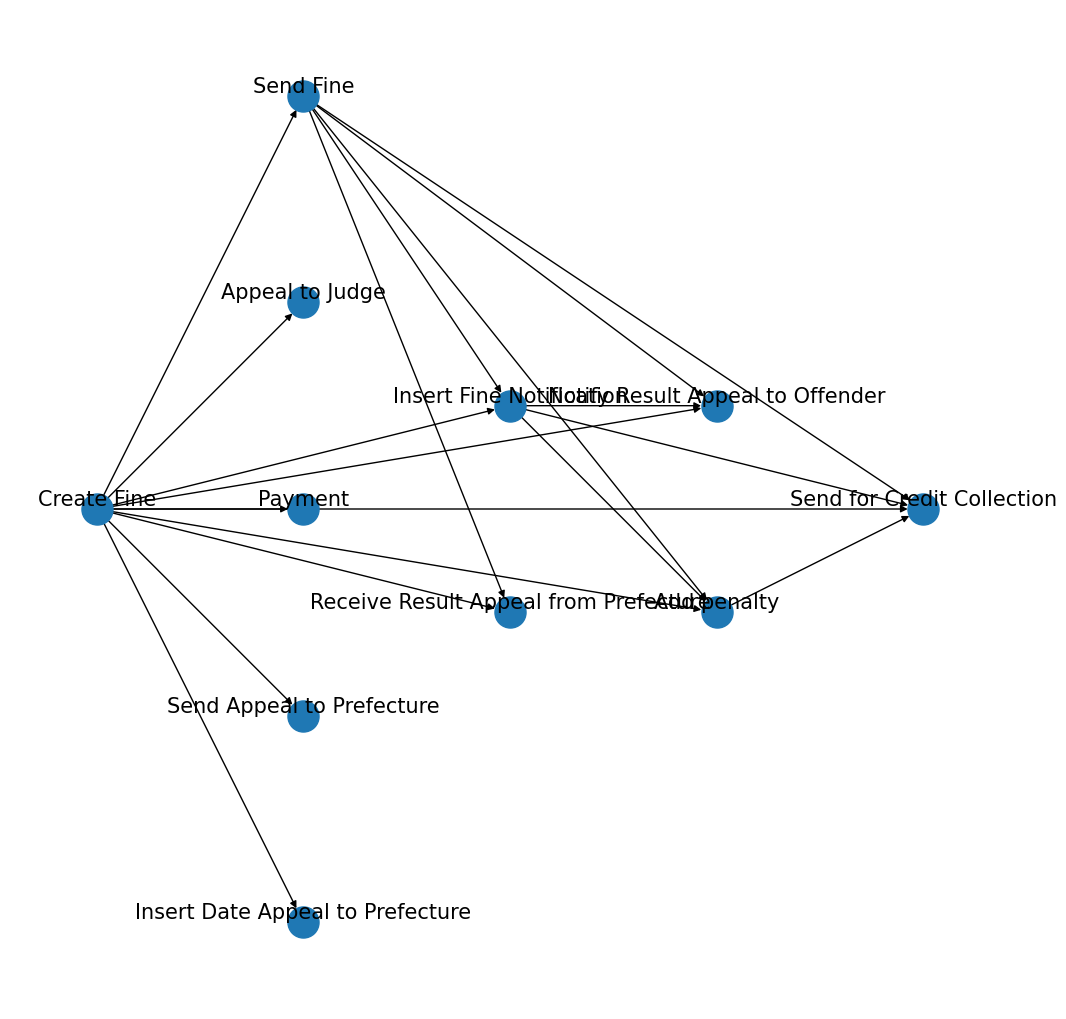

In [4]:
data_filler_adj_matrix = {}
i = len(events)
adj_matrix = np.array([[0 for i in range(len(events_and_data))] for j in range(len(events_and_data))])
idx_dict = {}
for i, e1 in enumerate(events_and_data):
    idx_dict[e1] = i
    for j, e2 in enumerate(events_and_data):
        if e1 in log_abs['precedenceFor'] and e2 in log_abs['precedenceFor'][e1]:
            adj_matrix[j][i] = 1

for e, ds in data_filler_adj_matrix.items():
    for d in ds:
        i = idx_dict[e]
        j = idx_dict[d]
        adj_matrix[j][i] = 1

labels = {i:l for i,l in enumerate(events_and_data)}
show_graph_with_labels(adj_matrix, labels)

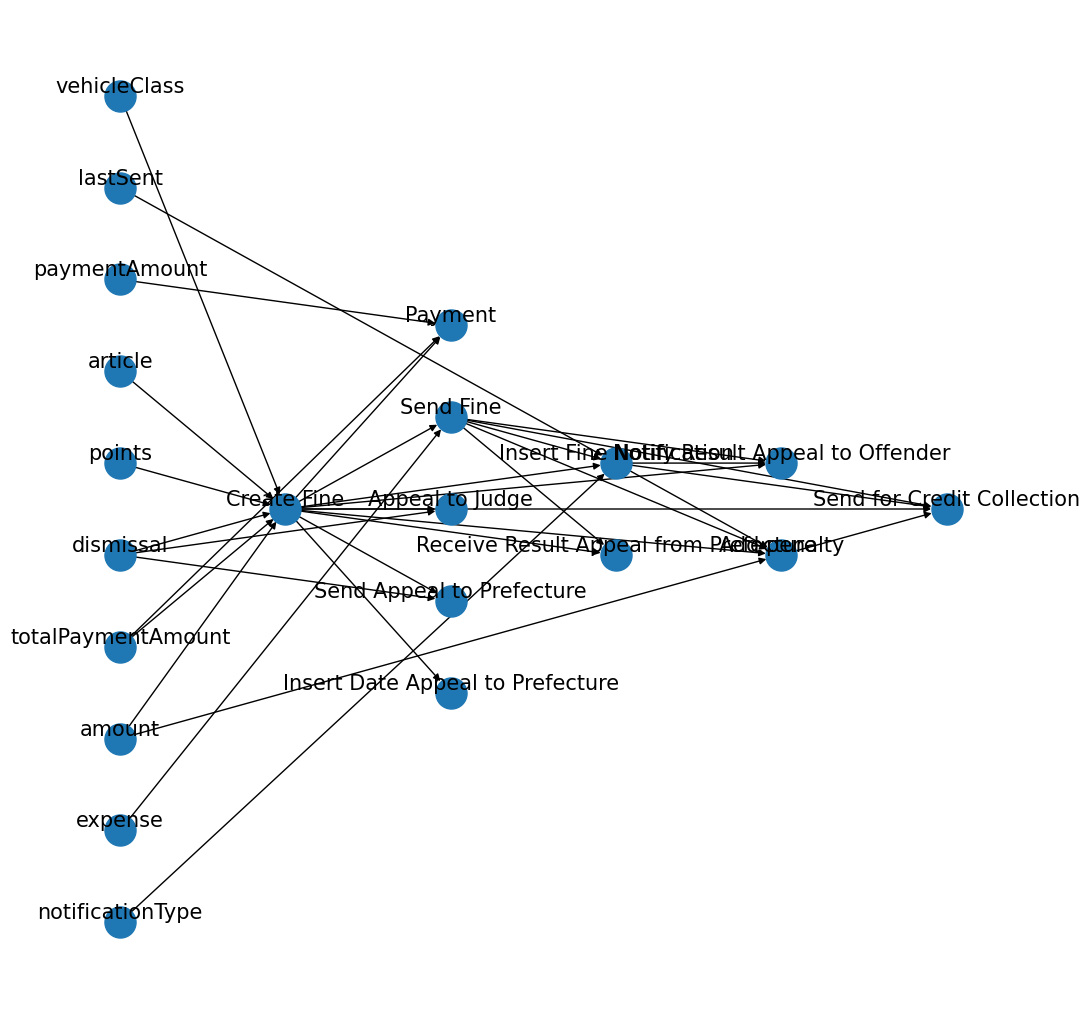

In [5]:
events_and_data = set(road_traffic_train['concept:name'].unique())
data_filler_adj_matrix = {}
i = len(events)
for e,a in domain_knowledge.items():
    ks = set()
    for k,v in a.items():
        if v!='ignore':
            events_and_data.add(k)
            i += 1
            ks.add(k)
    data_filler_adj_matrix[e] = ks
adj_matrix = np.array([[0 for i in range(len(events_and_data))] for j in range(len(events_and_data))])
idx_dict = {}
for i, e1 in enumerate(events_and_data):
    idx_dict[e1] = i
    for j, e2 in enumerate(events_and_data):
        if e1 in log_abs['precedenceFor'] and e2 in log_abs['precedenceFor'][e1]:
            adj_matrix[j][i] = 1

for e, ds in data_filler_adj_matrix.items():
    for d in ds:
        i = idx_dict[e]
        j = idx_dict[d]
        adj_matrix[j][i] = 1

labels = {i:l for i,l in enumerate(events_and_data)}
show_graph_with_labels(adj_matrix, labels)

In [6]:
events = set(road_traffic_train['concept:name'].unique())
event_and_data_functions = {}
event_and_plot_info = {}
for event in events:
    res = extract_event_binomial(event,road_traffic_train, unfolded=False)
    for etemp, (func, prob) in res.items():
        event_and_data_functions[etemp] = func
        event_and_plot_info[etemp] = prob
attribute_events = {}
attribute_data_type = {}
for event, attributes in domain_knowledge.items():
    for attr, data_type in attributes.items():
        if attr not in attribute_events.keys():
            attribute_events[attr] = [event]
            attribute_data_type[attr] = data_type
        else:
            attribute_events[attr].append(event)

for attr, data_type in attribute_data_type.items():
    if data_type == 'categorical':
        event_and_data_functions[attr], pdict = extract_categorical_data_attribute(attribute_events[attr],attr,road_traffic_train,group_threshold=-1)
        event_and_plot_info[attr] = pdict
    elif data_type == 'numerical':
        event_and_data_functions[attr] = extract_numerical_data_attribute(attribute_events[attr],attr,road_traffic_train)

observational_data_list = []

if os.path.isfile('../models/road_traffic_encoded.json'):
    with open('../models/road_traffic_encoded.json') as f:
        observational_data_list = json.load(f)

if len(observational_data_list)==0:
    n = road_traffic_train['case:concept:name'].nunique()
    for i, case_df in enumerate(road_traffic_train.groupby('case:concept:name')):
        data_dict = case_to_data_entry(case_df[1],events,attribute_data_type)
        observational_data_list.append(data_dict)
        # print(f'[i] {i+1}/{n} cid: {case_df[0]}')
        # if i+1 == 10000:
        #     break
    with open('../models/road_traffic_encoded.json', 'w') as f:
        json.dump(observational_data_list, f)

event_x_cols = {}
event_y_cols = {}

instant_effects = True

for event in events:
    precedence_events = set(log_abs['precedenceFor'][event])
    precedence_data_attributes = set()
    for precedence_event in precedence_events:
        if precedence_event in data_filler_adj_matrix:
            precedence_data_attributes = precedence_data_attributes.union(set(data_filler_adj_matrix[precedence_event]))
    if instant_effects and event in data_filler_adj_matrix:
        precedence_data_attributes = precedence_data_attributes.union(set(data_filler_adj_matrix[event]))
    precedence_events = precedence_events.union(precedence_data_attributes)
    event_x_cols[event] = precedence_events
    event_y_cols[event] = event

[i] Event Send for Credit Collection prob of success: 0.39
[i] Event Insert Fine Notification prob of success: 0.53
[i] Event Receive Result Appeal from Prefecture prob of success: 0.01
[i] Event Send Fine prob of success: 0.69
[i] Event Appeal to Judge prob of success: 0.00
[i] Event Notify Result Appeal to Offender prob of success: 0.01
[i] Event Payment prob of success: 0.46
[i] Event Send Appeal to Prefecture prob of success: 0.03
[i] Event Insert Date Appeal to Prefecture prob of success: 0.03
[i] Event Create Fine prob of success: 1.00
[i] Event Add penalty prob of success: 0.53
[i] For categorical data attribute: lastSent
[i] Data instance P prob of success 0.58
[i] Data instance N prob of success 0.38
[i] Data instance nan prob of success 0.02
[i] Data instance C prob of success 0.02
[i] For categorical data attribute: notificationType
[i] Data instance P prob of success 1.00
[i] Data instance C prob of success 0.00
paymentAmount ['Payment']


Fitting 10 distributions: 100%|██████████| 10/10 [00:00<00:00, 10.67it/s]


[i] For numerical data attribute: paymentAmount dist:cauchy params:{'loc': 35.71725760295883, 'scale': 3.9449684355957686}
totalPaymentAmount ['Payment', 'Create Fine']


Fitting 10 distributions: 100%|██████████| 10/10 [00:02<00:00,  3.54it/s]


[i] For numerical data attribute: totalPaymentAmount dist:lognorm params:{'s': 11.591215304963832, 'loc': -5.4232589948520995e-15, 'scale': 6.045311599483573}
[i] For categorical data attribute: dismissal
[i] Data instance NIL prob of success 0.98
[i] Data instance # prob of success 0.01
[i] Data instance A prob of success 0.00
[i] Data instance T prob of success 0.00
[i] Data instance G prob of success 0.00
[i] Data instance D prob of success 0.00
[i] Data instance I prob of success 0.00
[i] Data instance N prob of success 0.00
[i] Data instance U prob of success 0.00
[i] Data instance 5 prob of success 0.00
[i] Data instance V prob of success 0.00
[i] Data instance C prob of success 0.00
[i] Data instance @ prob of success 0.00
[i] Data instance E prob of success 0.00
[i] Data instance Z prob of success 0.00
[i] Data instance M prob of success 0.00
[i] Data instance F prob of success 0.00
[i] Data instance R prob of success 0.00
[i] Data instance K prob of success 0.00
[i] Data insta

Fitting 10 distributions: 100%|██████████| 10/10 [00:02<00:00,  4.18it/s]


[i] For numerical data attribute: amount dist:cauchy params:{'loc': 35.966524341590784, 'scale': 7.424979893162632}
expense ['Send Fine']


Fitting 10 distributions: 100%|██████████| 10/10 [00:01<00:00,  8.45it/s]


[i] For numerical data attribute: expense dist:cauchy params:{'loc': 12.429325462912338, 'scale': 1.8523165317377395}
[i] For categorical data attribute: vehicleClass
[i] Data instance A prob of success 0.98
[i] Data instance C prob of success 0.02
[i] Data instance M prob of success 0.01
[i] Data instance R prob of success 0.00
points ['Create Fine']


Fitting 10 distributions: 100%|██████████| 10/10 [00:01<00:00,  8.20it/s]


[i] For numerical data attribute: points dist:expon params:{'loc': 0.0, 'scale': 0.0788787657112456}
article ['Create Fine']


Fitting 10 distributions: 100%|██████████| 10/10 [00:01<00:00,  7.63it/s]


[i] For numerical data attribute: article dist:cauchy params:{'loc': 157.12297468223926, 'scale': 0.6451193518760909}


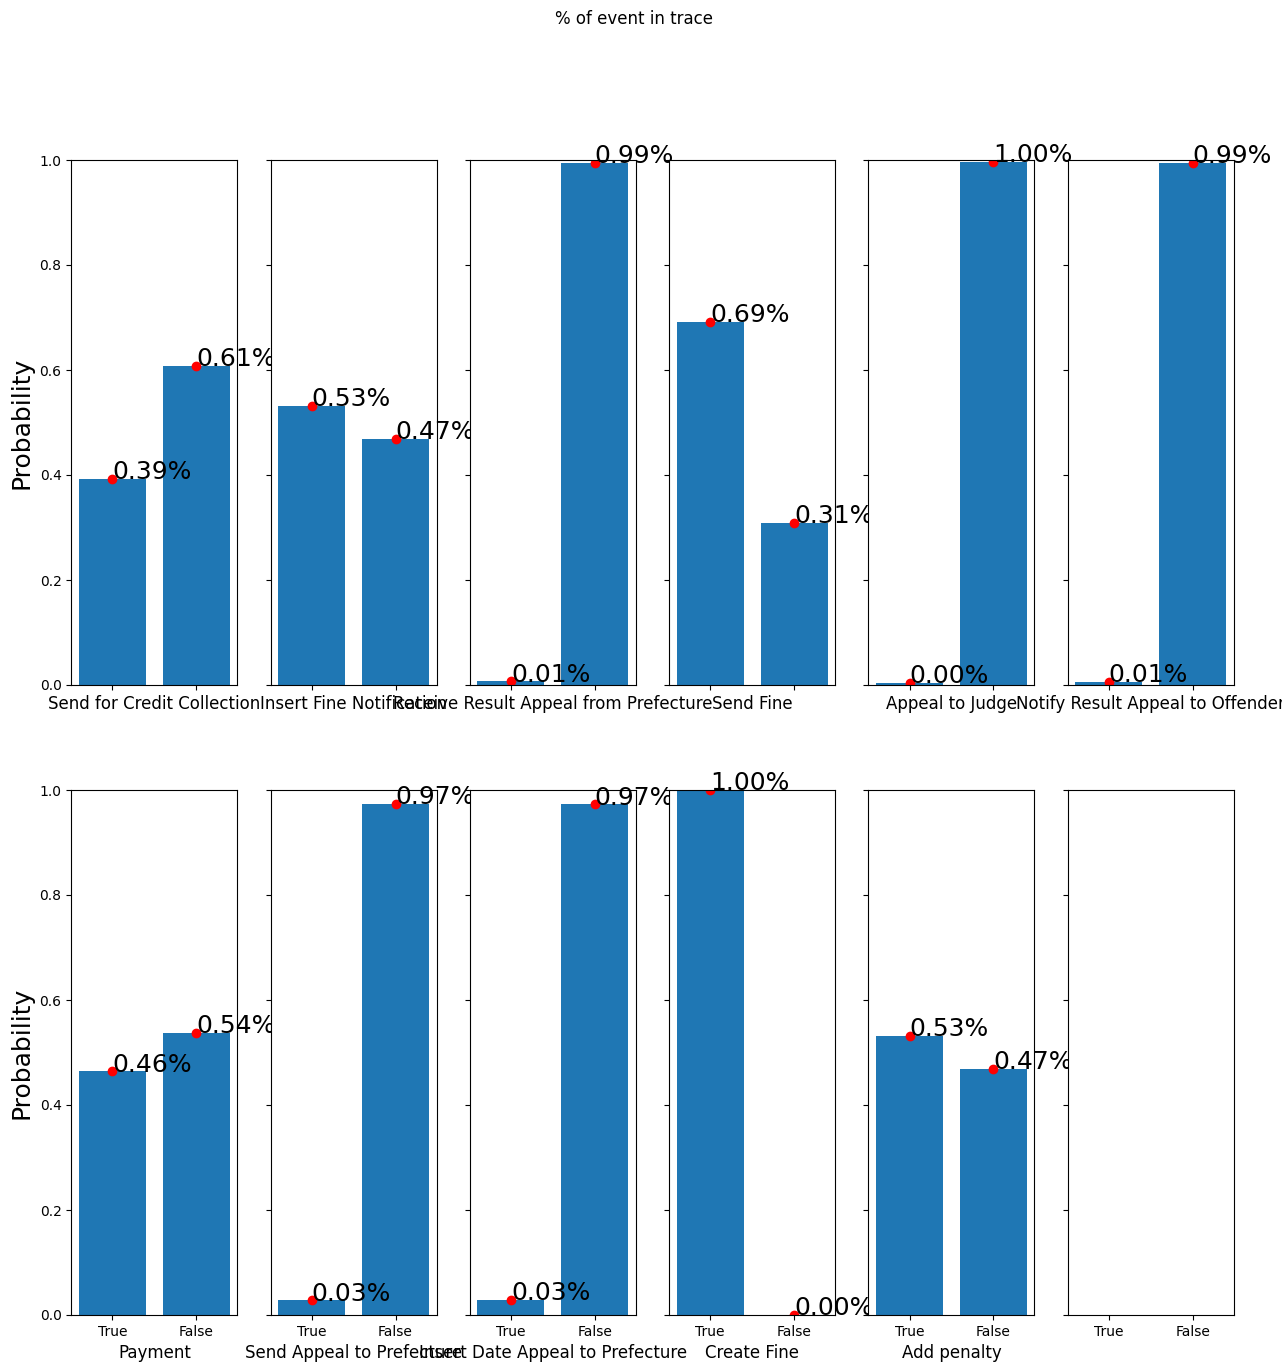

In [7]:
fig, axs = plt.subplots(2, 6,figsize=(15,15),sharey=True,sharex=True)
fig.suptitle('% of event in trace')
axs[0,0].set_ylabel('Probability', fontsize=18)
axs[1,0].set_ylabel('Probability', fontsize=18)
k = 0
col = 6
for i, event in enumerate(events):
    if i == col:
        k = 1
    p = event_and_plot_info[event]
    p = [p,1-p]
    x = [0,1]
    axs[k,i % col].bar(x, p)
    axs[k,i % col].scatter(x, p, marker='o', color='red')
    for z, txt in enumerate(p):
        axs[k,i % col].annotate('{:.2f}%'.format(txt), (x[z], p[z]), fontsize=18)
    axs[k,i % col].set_xticks(ticks=x, labels=['True','False'])
    axs[k,i % col].set_xlabel(event, fontsize = 12)
    axs[k,i % col].set_ylim([0, 1])
    # plt.legend(loc=(0.5,0.8), fontsize = 15)

plt.show()

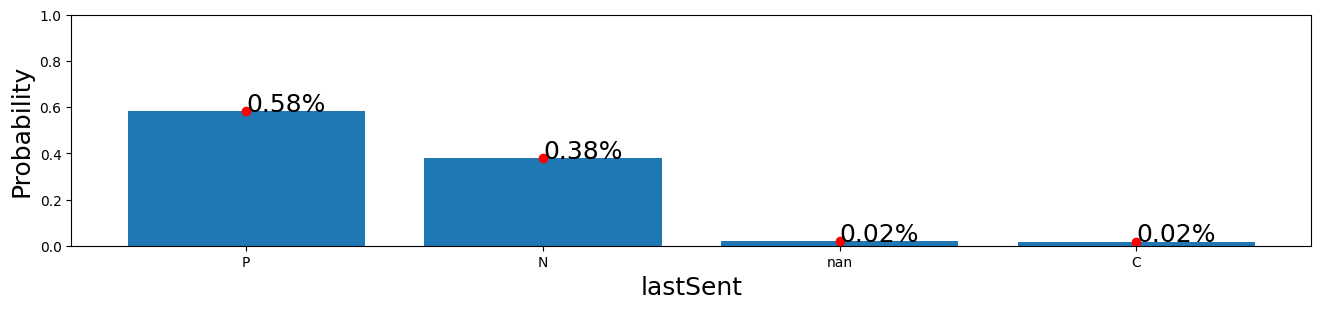

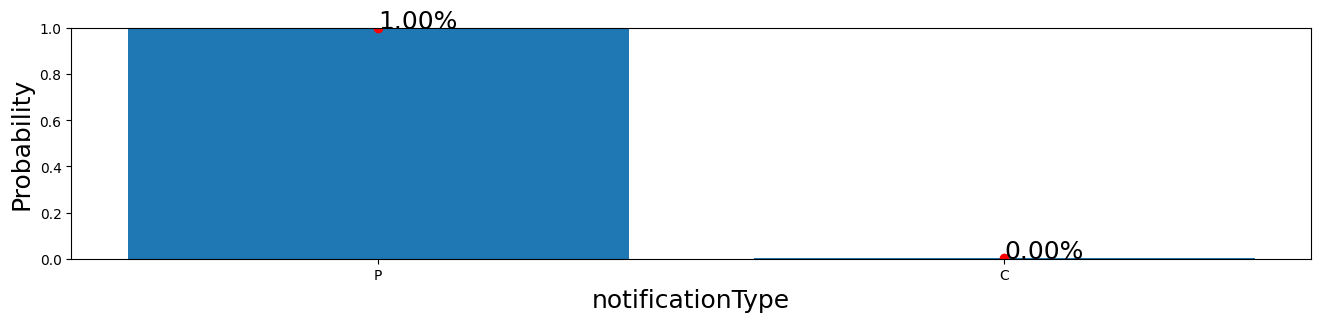

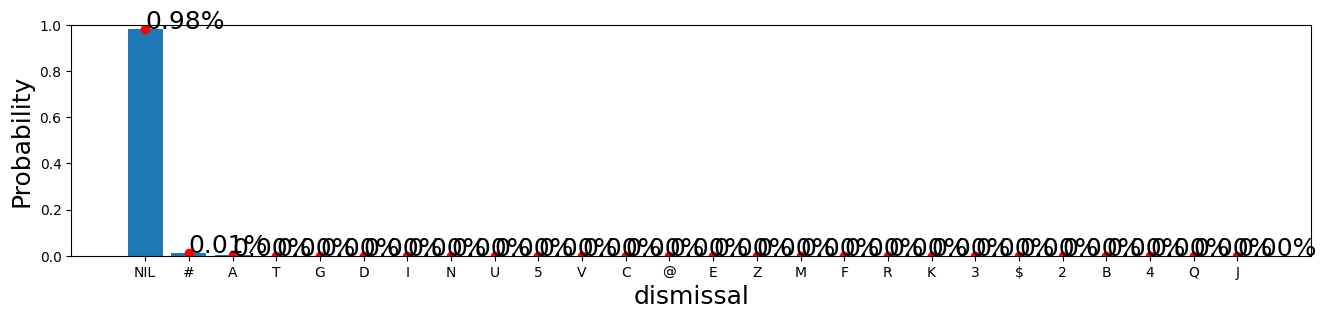

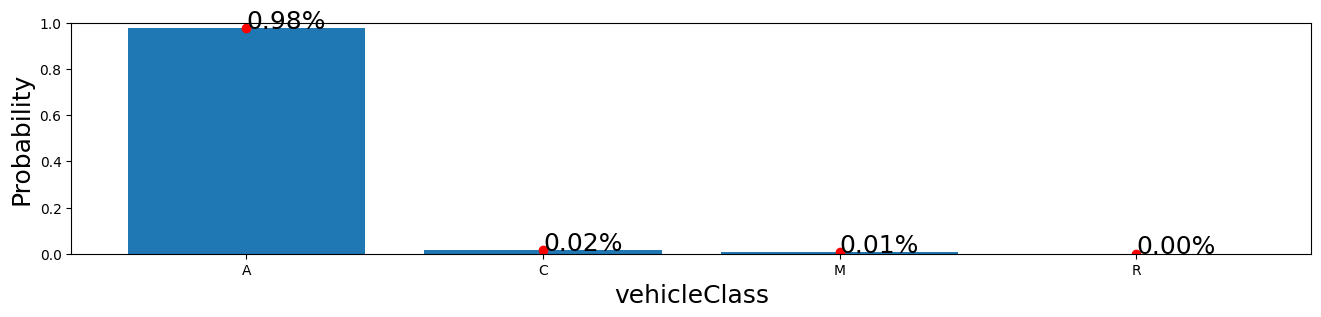

In [8]:
cat_attrs_to_plot = ['lastSent','notificationType','dismissal','vehicleClass']
for attr in cat_attrs_to_plot:
    n = len(event_and_plot_info[attr])
    p= [v for k,v in event_and_plot_info[attr].items()]
    x = np.arange(n)
    
    fig = plt.figure(figsize=(16, 3))
    plt.bar(x, p)
    plt.scatter(x, p, marker='o', color='red')
    for i, txt in enumerate(p):
        plt.annotate('{:.2f}%'.format(txt), (x[i], p[i]), fontsize=18)
    plt.xticks(ticks=x, labels=[k for k,v in event_and_plot_info[attr].items()])
    plt.xlabel(attr, fontsize = 18)
    plt.ylabel('Probability', fontsize=18)
    plt.ylim([0, 1])
    # plt.legend(loc=(0.5,0.8), fontsize = 15)
    plt.show()

Fitting 10 distributions: 100%|██████████| 10/10 [00:00<00:00, 40.97it/s]


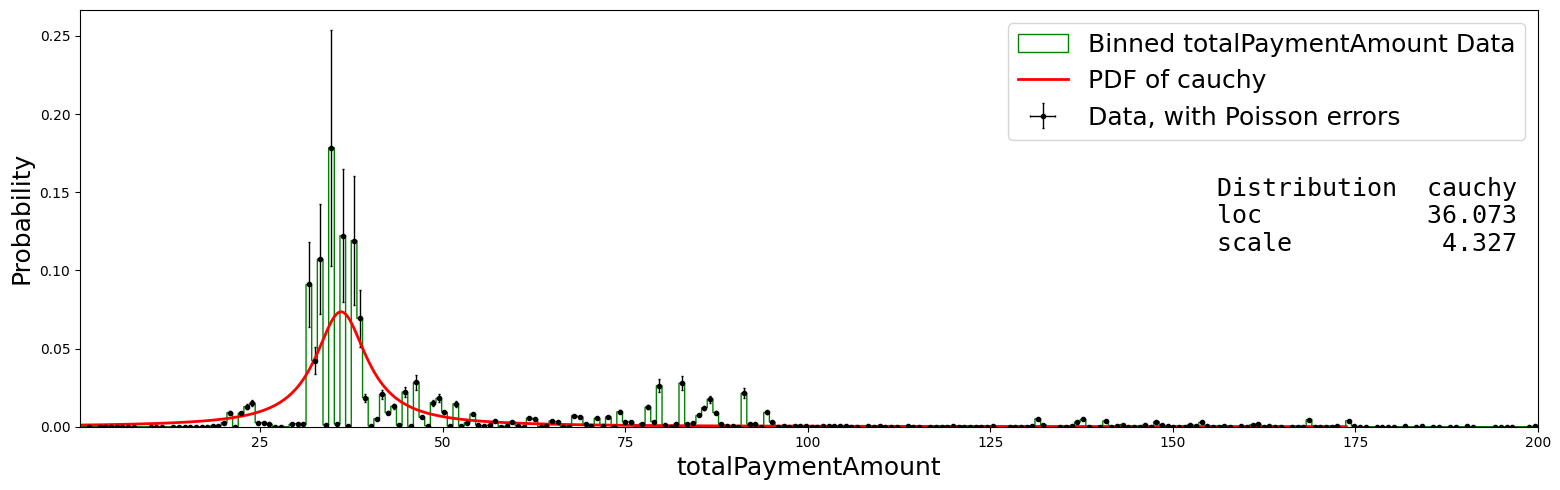

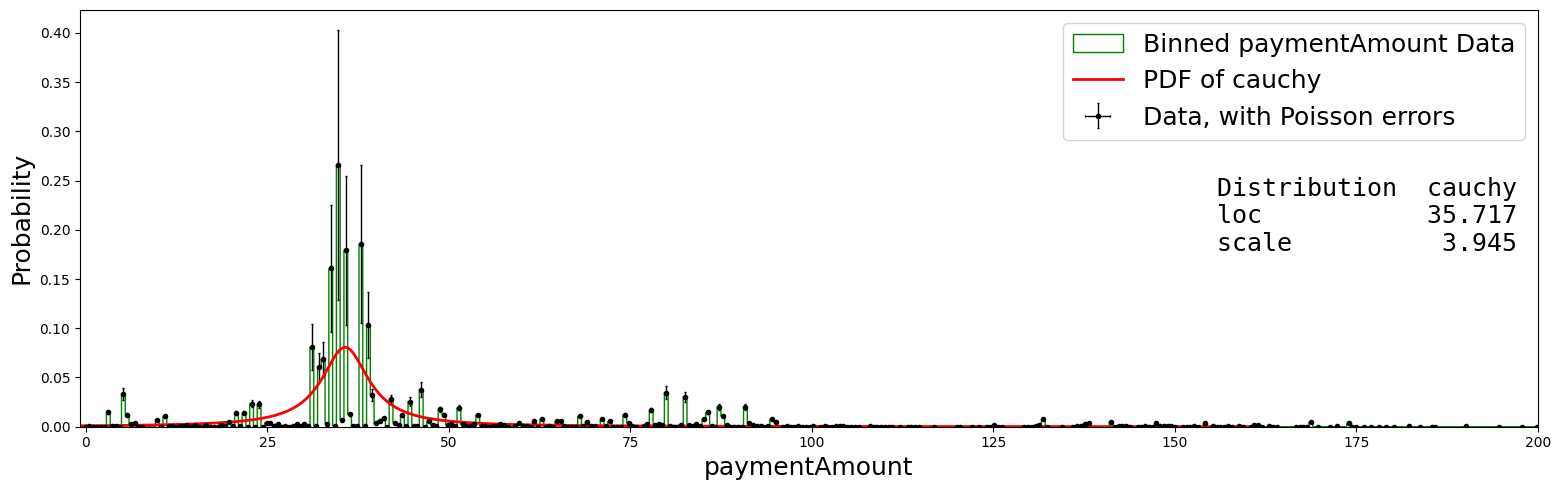

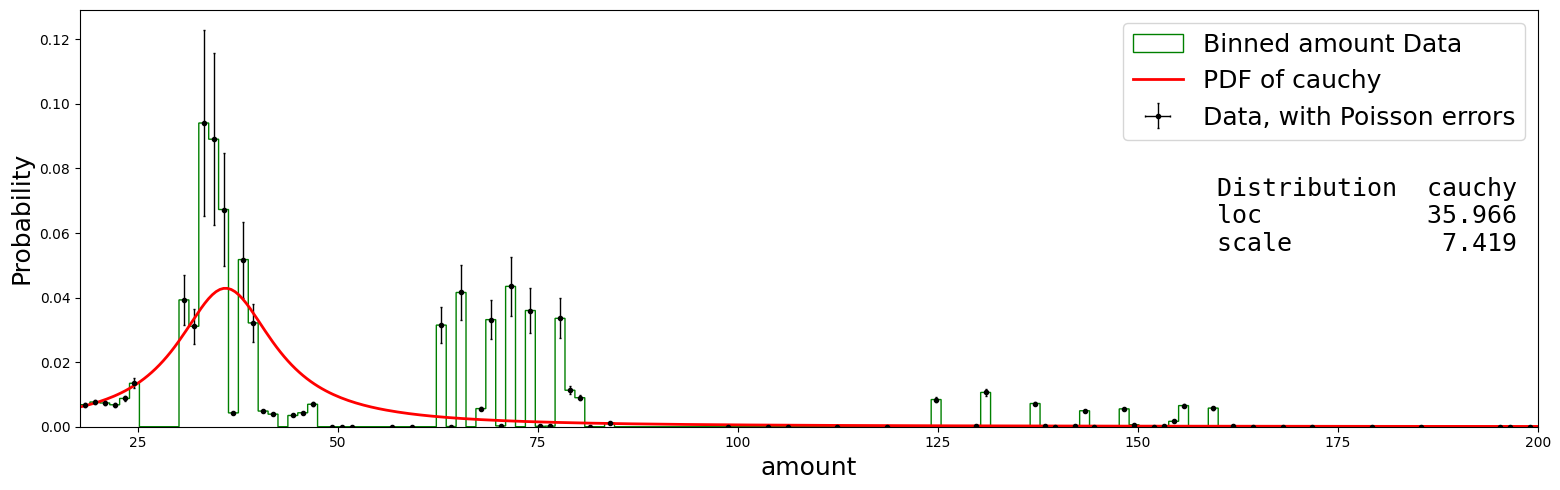

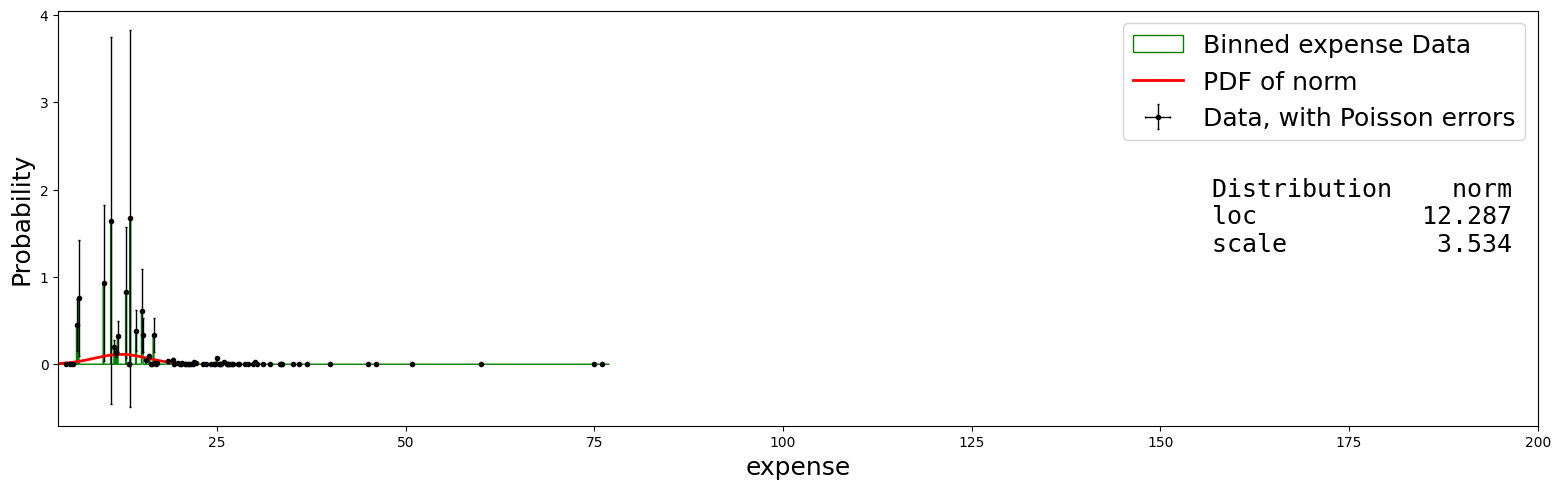

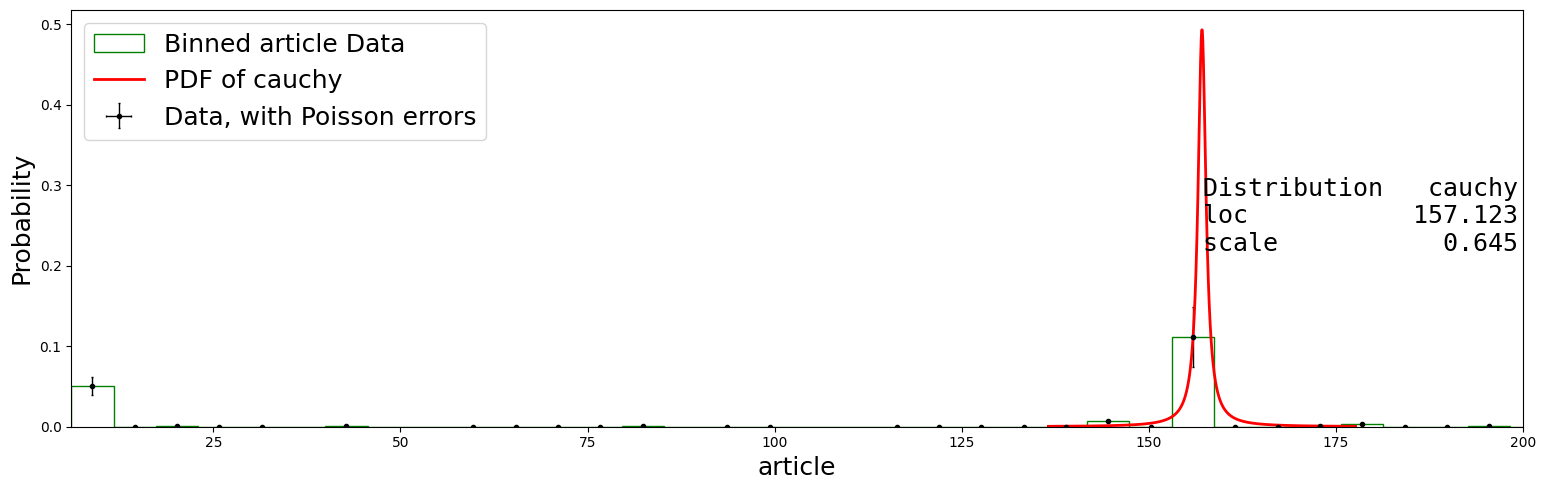

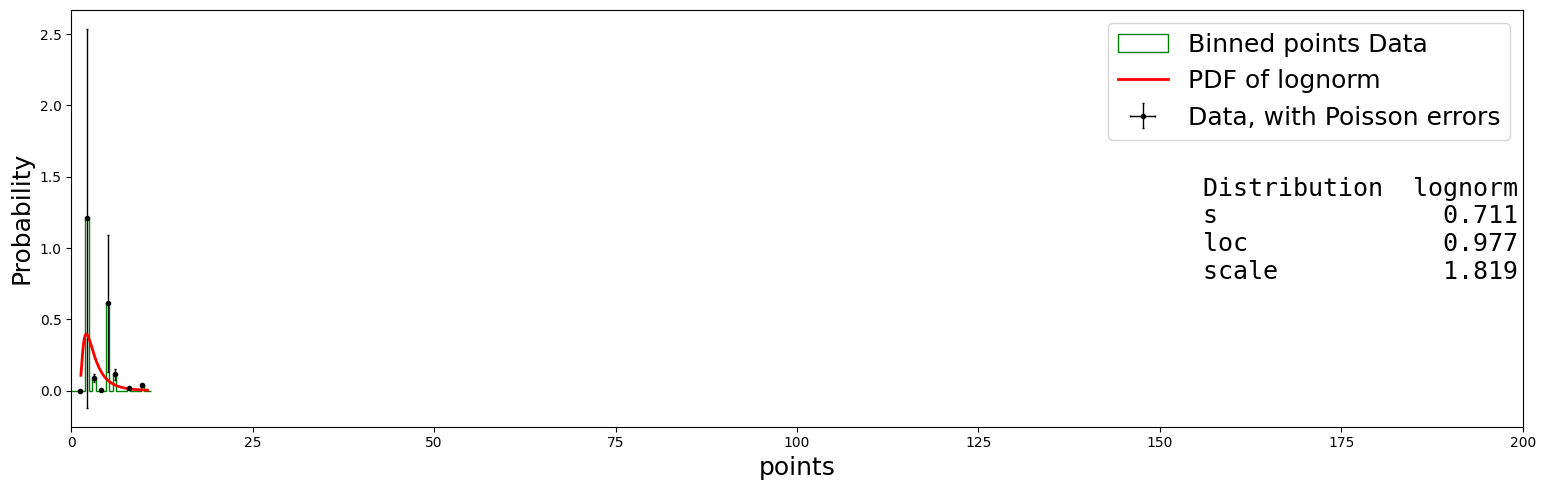

In [9]:
parent_event_dict = {v1:k for k,v in domain_knowledge.items() for v1, _ in v.items()}

for data_attribute in ['totalPaymentAmount','paymentAmount','amount','expense','article','points']: 
    density = True
    paradata = road_traffic_train[road_traffic_train[data_attribute]>0][data_attribute].dropna()
    xmin = min(paradata)-1
    xmax = max(paradata)+1
    Nbins, binwidth = freedman_diaconis_rule(paradata)
    counts, bin_edges = np.histogram(paradata, bins=Nbins, range=(xmin, xmax),density=density)
    x = (bin_edges[1:][counts > 0] + bin_edges[:-1][counts > 0]) / 2
    y = counts[counts > 0]
    sy = np.sqrt(counts[counts > 0])
    if density:
        sy = sy*counts[counts > 0]
    fig, ax = plt.subplots(figsize=(16, 5))
    counts, bins, bars = ax.hist(paradata, bins=Nbins, range=(xmin, xmax), histtype='step',
                                                     density=density, alpha=1, color='g',
                                                     label=f'Binned {data_attribute} Data')
    ax.errorbar(x, y, yerr=sy, xerr=0.0, label='Data, with Poisson errors', fmt='.k',
                                   ecolor='k',
                                   elinewidth=1, capsize=1, capthick=1)
    f = Fitter(paradata, distributions=get_common_distributions(),timeout=2*60,bins=Nbins,density=density)
    f.fit()
    # here you get the rss fit scores
    res = f.summary(plot=False)
    residual_sumssquare_error = res.iloc[0].sumsquare_error
    aic = res.iloc[0].aic
    kl_div = res.iloc[0].kl_div
    best_dist, fitted_params = f.get_best().popitem()

    size = 1000
    dist_func = getattr(stats,best_dist)
    start = dist_func.ppf(0.01, **fitted_params)
    end = dist_func.ppf(0.99, **fitted_params)
    x = np.linspace(start, end, size)
    y = dist_func.pdf(x, **fitted_params)
    pdf = pd.Series(y, x)
    pdf.plot(lw=2, label=f'PDF of {best_dist}', color='r', legend=True)

    # ax.plot(f.fitted_pdf[best_dist],label=f'Best fit {best_dist}')
    d = {'Distribution':f'{best_dist}',
         **fitted_params}
    text = nice_string_output(d, extra_spacing=2, decimals=3)
    add_text_to_ax(0.78, 0.6, text, ax, fontsize=18)
    ax.set_xlabel(f'{data_attribute}', fontsize=18)
    ax.set_ylabel('Probability', fontsize=18)
    xmax = 200
    ax.set_xlim([xmin,xmax])
    # ax.set_ylim([0,0.012])

    # ax.set_title(f'Numerical data fit for {data_attribute}"')
    ax.legend(fontsize=18)
    fig.tight_layout()

In [10]:
observational_data = pd.DataFrame(observational_data_list,columns=list(event_and_data_functions.keys()))
observational_data = observational_data.fillna(0)
for attr, data_type in attribute_data_type.items():
    if data_type == 'categorical':
        onehot = pd.get_dummies(observational_data[attr],dummy_na=False,prefix=attr)
        observational_data = pd.concat([observational_data,onehot],axis=1)
        observational_data = observational_data.drop(attr,axis=1)
    elif data_type == 'numerical':
        # mean normalization
        #pass
        observational_data[attr] = (observational_data[attr]-observational_data[attr].mean())/observational_data[attr].std()

In [23]:
import random

from sklearn.linear_model import LogisticRegression,LinearRegression

In [11]:
def linear_logistic_fits(target,x_cols):
    y_cols = target
    split_at_80 = int(len(observational_data)*4/5)
    if y_cols not in ['totalPaymentAmount','paymentAmount','amount','expense','article','points','Create Fine']:
        print(f'Logistic started for: {y_cols}')
        clf = LogisticRegression(max_iter=1000)
        model = clf.fit(observational_data[list(x_cols)][:split_at_80], observational_data[y_cols][:split_at_80])
        print(f'[i] logistic score: {model.score(observational_data[list(x_cols)][split_at_80:],observational_data[y_cols][split_at_80:])}')
        to_print = ''
        for x,y in zip(x_cols,model.coef_[0]):
            to_print+= str(round(y,2))+'*('+ x + ') '
        print(f'[i] {y_cols} = [{to_print}] + Intercept*{round(model.intercept_[0],2)}')
    print(f'Linear started for: {y_cols}')
    clf = LinearRegression()
    model = clf.fit(observational_data[list(x_cols)][:split_at_80], observational_data[y_cols][:split_at_80])
    print(f'[i] linear score: {model.score(observational_data[list(x_cols)][split_at_80:],observational_data[y_cols][split_at_80:])}')
    to_print = ''
    for x,y in zip(x_cols,model.coef_):
        to_print+= str(round(y,2))+'*('+ x + ') '
    print(f'[i] {y_cols} = [{to_print}] + Intercept*{round(model.intercept_,2)}')

In [12]:
ignore_dismissal = [c for c in observational_data.columns if c.startswith('dismissal')]

In [13]:
for target in set(observational_data.columns).difference(ignore_dismissal):
    x_cols = observational_data.columns.drop(target)
    x_cols = x_cols.difference(ignore_dismissal)
    linear_logistic_fits(target,x_cols)

Linear started for: paymentAmount
[i] linear score: 0.8654247251587306
[i] paymentAmount = [11630740898.72*(Add penalty) -0.07*(Appeal to Judge) -10164198.48*(Create Fine) -0.38*(Insert Date Appeal to Prefecture) 4473417265.48*(Insert Fine Notification) 0.03*(Notify Result Appeal to Offender) 0.23*(Payment) 0.14*(Receive Result Appeal from Prefecture) 0.58*(Send Appeal to Prefecture) 0.05*(Send Fine) 0.24*(Send for Credit Collection) -0.01*(amount) 0.0*(article) -0.02*(expense) -1589998201.46*(lastSent_0) -1589998201.39*(lastSent_C) -1589998201.55*(lastSent_N) -1589998201.46*(lastSent_P) -4479272651.25*(notificationType_0) -20583430815.41*(notificationType_C) -20583430815.65*(notificationType_P) 0.01*(points) 0.92*(totalPaymentAmount) -12132756968.96*(vehicleClass_A) -12132756968.95*(vehicleClass_C) -12132756968.94*(vehicleClass_M) -12132756969.05*(vehicleClass_R) ] + Intercept*18212192020.03
Linear started for: article
[i] linear score: -0.04363327277818163
[i] article = [-14099898678

2 datasets: disjoint datasets


#TODO: try chi-square test with both categorical and numerical variables.

In [14]:
observational_data

,Send for Credit Collection,Insert Fine Notification,Receive Result Appeal from Prefecture,Send Fine,Appeal to Judge,Notify Result Appeal to Offender,Payment,Send Appeal to Prefecture,Insert Date Appeal to Prefecture,Create Fine,...,dismissal_Q,dismissal_R,dismissal_T,dismissal_U,dismissal_V,dismissal_Z,vehicleClass_A,vehicleClass_C,vehicleClass_M,vehicleClass_R
0,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
1,1,1,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
2,0,1,0,1,0,0,1,0,0,1,...,0,0,0,0,0,0,1,0,0,0
3,0,1,0,1,0,0,0,1,1,1,...,0,0,0,0,0,0,1,0,0,0
4,1,1,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150365,1,1,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
150366,0,0,0,1,0,0,1,0,0,1,...,0,0,0,0,0,0,1,0,0,0
150367,1,1,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
150368,1,1,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0


In [80]:
observational_data = pd.DataFrame(observational_data_list,columns=list(event_and_data_functions.keys()))
observational_data = observational_data.fillna(0)
for attr, data_type in attribute_data_type.items():
    if data_type == 'categorical':
        onehot = pd.get_dummies(observational_data[attr],dummy_na=False,prefix=attr)
        observational_data = pd.concat([observational_data,onehot],axis=1)
        observational_data = observational_data.drop(attr,axis=1)
    elif data_type == 'numerical':
        # mean normalization
        #pass
        observational_data[attr] = (observational_data[attr]-observational_data[attr].mean())/observational_data[attr].std()

In [75]:
percent = 9/10
n = int(len(observational_data)*percent)
x = observational_data.index.values    
np.random.shuffle(x)
observational_data.loc[x[:n],'Add penalty'] = observational_data['Payment']

In [81]:
percent = 9/10
n = int(len(observational_data)*percent)
x = observational_data.index.values    
np.random.shuffle(x)
observational_data.loc[x[:n],'Send Fine'] = observational_data['Payment']

Logistic started for: Payment
[i] logistic score: 0.9999667486865731
[i] Payment = [-0.66*(amount) -0.19*(points) -1.43*(Add penalty) 7.31*(totalPaymentAmount) -0.2*(article) 10.27*(Send Fine) ] + Intercept*-3.64
Linear started for: Payment
[i] linear score: 1.0
[i] Payment = [-0.0*(amount) -0.0*(points) -0.0*(Add penalty) 0.0*(totalPaymentAmount) -0.0*(article) 1.0*(Send Fine) ] + Intercept*0.0
[icp i=0]  ['amount', 'article', 'Send Fine'] causal effect for "Payment"
[icp i=1]  ['article', 'Send Fine'] causal effect for "Payment"
[icp i=2]  ['amount', 'points', 'Add penalty', 'totalPaymentAmount', 'article', 'Send Fine'] causal effect for "Payment"
[icp i=3]  ['article', 'Send Fine'] causal effect for "Payment"
[icp i=4]  ['amount', 'Add penalty', 'totalPaymentAmount', 'article', 'Send Fine'] causal effect for "Payment"
[icp i=5]  ['amount', 'points', 'article', 'Send Fine'] causal effect for "Payment"
[icp i=7]  ['amount', 'totalPaymentAmount', 'Send Fine'] causal effect for "Payment

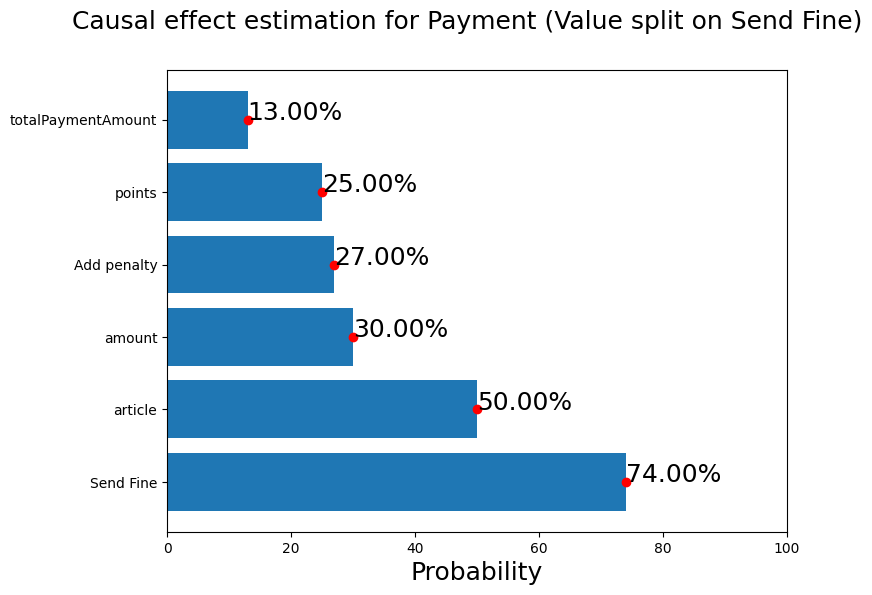

In [82]:
cols = ['Payment','amount','points','Add penalty','totalPaymentAmount','article','Send Fine']
# for i in range(len(cols)):
target_idx = 0
x_cols = deepcopy(cols)
x_cols.remove(cols[target_idx])
linear_logistic_fits(cols[target_idx],x_cols)
#data is a list of matrices
res_hist = {}

sample_size = 100

env_split_event = 'Send Fine'

for v in x_cols:
    res_hist[v] = 0
for i in range(100):
    s0 = observational_data[observational_data[env_split_event]==1][cols]
    # print(s0.index)
    if sample_size>0:
        s0 = s0.sample(sample_size)
    data = [s0.to_numpy()]
    s1 = observational_data[observational_data[env_split_event]==0][cols]
    # print(s1.index)
    if sample_size>0:
        s1 = s1.sample(sample_size)
    data += [s1.to_numpy()]
    # data = [observational_data[observational_data['Send Fine']==1][cols].to_numpy()[:100,:]]
    # data += [observational_data[observational_data['Send Fine']==0][cols].to_numpy()[:100,:]]
    # data = [observational_data[cols].sample(100).to_numpy()]
    # data += [observational_data[cols].sample(100).to_numpy()]
    #To test: add a column which is highly correlated with the outcome (target) and check as we add more data (rows) we loose the signal.
    # noise = [np.random.normal(0,0.1,data[0].shape)]
    # data[0] = data[0] + noise[0]
    # for k in range(len(data)-1):
        # noise += [np.random.normal(0,0.1,data[k+1].shape)]
        # data[k+1] = data[k+1] + noise[k+1]
    
    res = icp.fit(data,target=target_idx, precompute=False, verbose=False, color=False)
    if res and res.estimate:
       print(f'[icp i={i}]  {[cols[k] for k in res.estimate]} causal effect for "{cols[res.target]}"')
       for x in res.estimate:
           res_hist[cols[x]] += 1
    elif sample_size<=0:
        print(f'[no  i={i}]')
for k,v in dict(sorted(res_hist.items(), key=lambda item: item[1])).items():
    print(f'[res] {k}:{v}')

res_hist = {k: v for k, v in sorted(res_hist.items(),reverse=True, key=lambda item: item[1])}
n = len(res_hist)
p= [v for k,v in res_hist.items()]
x = np.arange(n)

fig = plt.figure(figsize=(8, 6))
plt.barh(x, p)
plt.scatter(p,x, marker='o', color='red')
for i, txt in enumerate(p):
    plt.annotate('{:.2f}%'.format(txt), (p[i], x[i]), fontsize=18)
plt.yticks(ticks=x, labels=[k for k,v in res_hist.items()])
plt.suptitle(f'Causal effect estimation for {cols[res.target]} (Value split on {env_split_event})', fontsize = 18)
# plt.ylabel(f'Causal effect estimation for {cols[res.target]}', fontsize = 18)
plt.xlabel('Probability', fontsize=18)
plt.xlim([0, 100])
# plt.legend(loc=(0.5,0.8), fontsize = 15)
plt.show()

In [ ]:
observational_data.drop(columns=ignore_dismissal).corr()

In [ ]:
cols = ['Payment','Send Fine','Add penalty','Send for Credit Collection','points','article','amount','totalPaymentAmount']
# for i in range(len(cols)):
target_idx = 0
n_splits = 10
s = int(len(observational_data)/n_splits)
splits = [(i+1)*s for i in range(n_splits-1)]
data = [observational_data[:splits[0]][cols].to_numpy()]
for i in range(len(splits)-1):
    data += [observational_data[splits[i]:splits[i+1]][cols].to_numpy()]
data += [observational_data[splits[len(splits)-1]:][cols].to_numpy()]

noise = [np.random.normal(0,0.001,data[0].shape)]
data[0] = data[0] + noise[0]

for k in range(len(data)-1):
    noise += [np.random.normal(0,0.1,data[k+1].shape)]
    data[k+1] = data[k+1] + noise[k+1]

res = icp.fit(data,target=target_idx, precompute=False, verbose=True, color=False)
if res and res.estimate:
    print(f'[icp]  {[cols[k] for k in res.estimate]} causal precedence for "{cols[res.target]}"')